# Kaggle March Madness Challenge 2018

### Importing Packages

In [21]:
import os
path = os.getcwd()
print(path)

C:\Users\Owner\Documents\GitHub\March-Madness-2018


In [7]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [24]:
#data_dir = r'C:\Users\Owner\Documents\GitHub\March-Madness-2018\DataFiles'
df_seeds = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneySeeds.csv')
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')

In [25]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [26]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Seed Based Logistic Regression
Using just seeding the predict winner and confidence, use this as baseline model

In [27]:
# Convert seed to int
df_seeds['Seed_int'] = df_seeds['Seed'].str[1:3]
df_seeds['Seed_int'] = df_seeds['Seed_int'].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [28]:
# Drop unnecessary columns
df_seeds.drop(labels=['Seed'], inplace=True, axis=1)
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [29]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [30]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [31]:
# Merge dataframes
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [33]:
# Create training data set
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [34]:
X_train = df_predictions['SeedDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [35]:
# Create and test model
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5532, with best C: 0.021544346900318846


In [36]:
# Store model results
df_results = pd.DataFrame({'Type': ['Seed Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss'])
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553182


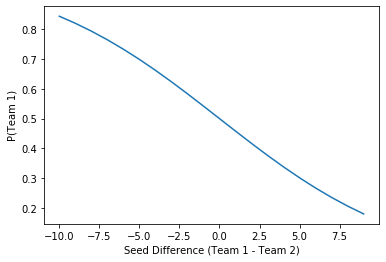

In [37]:
# Vizualization
X = np.arange(-10, 10).reshape(-1, 1);
preds = clf.predict_proba(X)[:,1];

plt.plot(X, preds);
plt.xlabel('Seed Difference (Team 1 - Team 2)');
plt.ylabel('P(Team 1)');

### Average Ranking Based Logistic Regression Model

In [43]:
df_massey = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/MasseyOrdinals.csv')

In [44]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [45]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey['RankingDayNum'] == final_day]
df_final_rankings = df_final_rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={'OrdinalRank':'Avg. Rank'}, inplace=True)

In [46]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [48]:
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [49]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(columns={'TeamID':'WTeamID', 'Avg. Rank':'WAvgRank'})
df_loss_ranks = df_final_rankings.rename(columns={'TeamID':'LTeamID', 'Avg. Rank':'LAvgRank'})
df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
df_concat['ScoreDiff'] = df_concat['WScore'] - df_concat['LScore']
df_concat['RankDiff'] = df_concat['WAvgRank'] - df_concat['LAvgRank']
df_total = df_concat[['Season', 'DayNum', 'WTeamID','LTeamID', 'WAvgRank', 'LAvgRank', 'RankDiff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


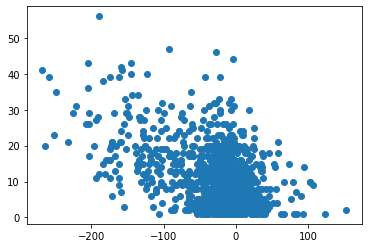

In [50]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat['RankDiff'], df_concat['ScoreDiff']);

In [51]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins['RankDiff'] = df_total['RankDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['RankDiff'] = -df_total['RankDiff']
df_losses['Result'] = 0

In [52]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [53]:
X_train = df_predictions['RankDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [54]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.548, with best C: 0.0001291549665014884


In [55]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['Avg. Ranking Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553182
0,Avg. Ranking Based Logistic Regression,-0.547982


### FiveThirtyEight Elo Logistic Regression Implementation

In [56]:
# Homecourt Bonus
HOME_ADVANTAGE = 100 
# Learning rate
K = 22

In [59]:
# Load regular season data
rs = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/RegularSeasonCompactResults.csv')
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [60]:
# Teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

364

In [61]:
# Score lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [62]:
# New columns to help us iteratively update elos
rs['margin'] = rs.WScore - rs.LScore
rs['w_elo'] = None
rs['l_elo'] = None

In [63]:
# Elo calculation
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [64]:
# Check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [65]:
# Iterate through all games
preds = []
for i in range(rs.shape[0]):
    
    # Get key data from current row
    w = rs.at[i, 'WTeamID']
    l = rs.at[i, 'LTeamID']
    margin = rs.at[i, 'margin']
    wloc = rs.at[i, 'WLoc']
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)
    
    # Stores new elos in the games dataframe
    rs.loc[i, 'w_elo'] = elo_dict[w]
    rs.loc[i, 'l_elo'] = elo_dict[l]

In [66]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [67]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [68]:
season_elos.head()

,team_id,season,season_elo
134286,1101,2014,1317.05
139681,1101,2015,1201.11
145038,1101,2016,1213.74
150369,1101,2017,1233.86
3606,1102,1985,1404.46


In [69]:
# Logistic Regression
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season':'Season', 'season_elo':'W_Elo'}) #
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season':'Season', 'season_elo':'L_Elo'}) #
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1591.58,1611.14,-19.5577
1,1985,1120,1345,1571.38,1582.63,-11.2464
2,1985,1207,1250,1748.49,1430.35,318.145
3,1985,1229,1425,1582.04,1578.1,3.94023
4,1985,1242,1325,1615.96,1600.98,14.9841


In [70]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

In [71]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Elo_Diff,Result
0,-19.5577,1
1,-11.2464,1
2,318.145,1
3,3.94023,1
4,14.9841,1


In [72]:
X_train = df_predictions['Elo_Diff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [73]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5429, with best C: 0.0001291549665014884


In [74]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['FiveThirtyEight Elo Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553182
0,Avg. Ranking Based Logistic Regression,-0.547982
0,FiveThirtyEight Elo Logistic Regression,-0.542918


### Select Ranking Systems

In [79]:
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [80]:
# Get list of all ranking systems
ranking_types = df_massey['SystemName'].unique().tolist()
ranking_types = [e for e in ranking_types if e not in ('MIC', 'GC', 'RAG', 'TOL', 'EBB', 'BP5', 'MPI', 'BOW', 'CTL')]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [81]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == mytype)]
    df_type = df_type.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_type.rename(columns={'OrdinalRank':'Type Rank'}, inplace=True)

    df_win_ranks = df_type.rename(columns={'TeamID':'WTeamID', 'Type Rank':'WTypeRank'})
    df_loss_ranks = df_type.rename(columns={'TeamID':'LTeamID', 'Type Rank':'LTypeRank'})
    df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
    df_concat['RankDiff'] = df_concat['WTypeRank'] - df_concat['LTypeRank']
    df_total = df_concat[['Season', 'WTeamID','LTeamID', 'WTypeRank', 'LTypeRank', 'RankDiff']]
    
    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins['RankDiff'] = df_total['RankDiff']
        df_wins['Result'] = 1
        df_losses = pd.DataFrame()
        df_losses['RankDiff'] = -df_total['RankDiff']
        df_losses['Result'] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions['RankDiff'].values.reshape(-1,1)
        Y_train = df_predictions['Result'].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {'C': np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring='neg_log_loss', refit=True)
            clf.fit(X_train, Y_train)

            print('{} - Best log_loss: {:.4}, with best C: {}'.format(mytype, clf.best_score_, clf.best_params_['C']))
            return(pd.DataFrame({'Type': [mytype], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
        return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))
    return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))

In [82]:
df_type_scores = pd.DataFrame(columns=['Type', 'Log Loss'])
for mytype in ranking_types:
    df_type_scores = df_type_scores.append(logreg_type(mytype))

MOR - Best log_loss: -0.5528, with best C: 0.0001291549665014884
POM - Best log_loss: -0.5513, with best C: 0.0001291549665014884
RPI - Best log_loss: -0.5586, with best C: 0.0001291549665014884
SAG - Best log_loss: -0.5472, with best C: 0.0001291549665014884
WLK - Best log_loss: -0.5484, with best C: 0.0016681005372000592
RTH - Best log_loss: -0.5555, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5586, with best C: 0.0001291549665014884
COL - Best log_loss: -0.559, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.5562, with best C: 0.0001291549665014884


In [83]:
df_type_scores = df_type_scores.loc[df_type_scores['Log Loss'] != 999]
df_type_scores.sort_values(by='Log Loss', ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,SAG,-0.547203
0,WLK,-0.548398
0,POM,-0.551318
0,MOR,-0.552759
0,RTH,-0.555494
0,DOL,-0.556187
0,RPI,-0.558637
0,WOL,-0.558644
0,COL,-0.559034


### 1. FiveThirtyEight Elo Ratings Model

In [85]:
# How does Elo perform alone?
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season_elo':'W_Elo', 'season':'Season'})
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season_elo':'L_Elo', 'season':'Season'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,136,1116,1234,1591.58,1611.14,-19.5577
1,1985,136,1120,1345,1571.38,1582.63,-11.2464
2,1985,136,1207,1250,1748.49,1430.35,318.145
3,1985,136,1229,1425,1582.04,1578.1,3.94023
4,1985,136,1242,1325,1615.96,1600.98,14.9841


In [86]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result
0,1985,136,1116,1234,-19.5577,1
1,1985,136,1120,1345,-11.2464,1
2,1985,136,1207,1250,318.145,1
3,1985,136,1229,1425,3.94023,1
4,1985,136,1242,1325,14.9841,1


In [87]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

4158

In [88]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Elo_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Elo_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

-0.5453800732621753

In [89]:
# 2014-2017 results
Y_pred = clf.predict(X_test)
df_test['Elo_Pred'] = Y_pred
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result,Elo_Pred
2112,2017,146,1314,1246,17.9249,0,1
2113,2017,146,1376,1196,144.711,0,1
2114,2017,152,1211,1376,-242.598,0,0
2115,2017,152,1314,1332,-45.0282,0,0
2116,2017,154,1314,1211,-10.9314,0,0


In [90]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       252
           1       0.73      0.73      0.73       252

    accuracy                           0.73       504
   macro avg       0.73      0.73      0.73       504
weighted avg       0.73      0.73      0.73       504



### 2. Average Select Ranking Systems
We will pull and average the top performing rankings from our analysis before:
1. SAG 
2. WLK
3. POM
4. MOR

In [91]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != 'Elo']
df_topranks = df_topranks.rename(columns={'team_id':'Team_ID', 'season':'Season'}) 

df_temp = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'SAG')]
df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'WLK')]
df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp2.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'POM')]
df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'MOR')]
df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

df_topranks = pd.merge(left=df_topranks, right=df_temp, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp2, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp3, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp4, how='left', on=['Season', 'Team_ID'])

In [92]:
# Mean of all four systems
df_topranks['MeanRank'] = (df_topranks['SAG'] + df_topranks['WLK'] + df_topranks['POM'] + df_topranks['MOR']) / 4
df_topranks.dropna(inplace = True)
df_topranks.head()

,Team_ID,Season,season_elo,SAG,WLK,POM,MOR,MeanRank
0,1101,2014,1317.05,346.0,330.0,348.0,349.0,343.25
1,1101,2015,1201.11,336.0,332.0,332.0,346.0,336.50
2,1101,2016,1213.74,320.0,304.0,318.0,311.0,313.25
3,1101,2017,1233.86,305.0,307.0,300.0,317.0,307.25
22,1102,2003,1452.53,149.0,165.0,160.0,132.0,151.50


In [94]:
# Join with tournament dataframe
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_topranks.drop(labels=['SAG', 'WLK', 'POM', 'MOR'], inplace=True, axis=1)

df_win_elos = df_topranks.rename(columns={'Team_ID':'WTeamID', 'MeanRank':'W_MeanRank'})
df_loss_elos = df_topranks.rename(columns={'Team_ID':'LTeamID', 'MeanRank':'L_MeanRank'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['MeanRank_Diff'] = df_concat['W_MeanRank'] - df_concat['L_MeanRank']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1318.06,259.50,1288.79,264.50,-5.00
1,2003,136,1112,1436,2051.08,2.75,1442.8,160.50,-157.75
2,2003,136,1113,1272,1787.95,30.00,1833.37,22.00,8.00
3,2003,136,1141,1166,1663.71,45.00,1835.58,24.25,20.75
4,2003,136,1143,1301,1862.13,39.00,1825.56,44.00,-5.00


In [95]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['MeanRank_Diff'] = df_concat['MeanRank_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['MeanRank_Diff'] = -df_concat['MeanRank_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [96]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

1890

In [97]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['MeanRank_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['MeanRank_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf2.fit(X_train, Y_train)
clf2.score(X_train, Y_train)

-0.5450159997861028

In [98]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       252
           1       0.73      0.73      0.73       252

    accuracy                           0.73       504
   macro avg       0.73      0.73      0.73       504
weighted avg       0.73      0.73      0.73       504



### 3. Composite Model
Standardize the elo ratings and rankings and take the mean for logistic regression.

In [99]:
# Set up and drop null rows
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
df.head()

,Team_ID,Season,Elo,season_elo,MeanRank
0,1101,2014,1317.05,1317.05,343.25
1,1101,2015,1201.11,1201.11,336.50
2,1101,2016,1213.74,1213.74,313.25
3,1101,2017,1233.86,1233.86,307.25
22,1102,2003,1452.53,1452.53,151.50


In [100]:
# Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

In [101]:
# Model 1
df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
df.head()

# Model 2
#df['Composite Score'] = (df['Elo_Scaled'] + (df['MeanRank_Scaled'])) / 2
#df.head()

,Team_ID,Season,Elo,season_elo,MeanRank,Elo_Scaled,MeanRank_Scaled,Composite Score
0,1101,2014,1317.05,1317.05,343.25,0.377452,0.022143,0.140579
1,1101,2015,1201.11,1201.11,336.50,0.289849,0.041429,0.124235
2,1101,2016,1213.74,1213.74,313.25,0.299388,0.107857,0.171701
3,1101,2017,1233.86,1233.86,307.25,0.314596,0.125000,0.188199
22,1102,2003,1452.53,1452.53,151.50,0.479827,0.570000,0.539942


In [102]:
# Join tournament dataframe
df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Composite_Diff'] = df_concat['W_Composite'] - df_concat['L_Composite']
df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite', 'Composite_Diff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite,Composite_Diff
0,2003,134,1421,1411,0.300359,0.283463,0.016896
1,2003,136,1112,1436,0.974035,0.520350,0.453685
2,2003,136,1113,1272,0.855856,0.882532,-0.026676
3,2003,136,1141,1166,0.795989,0.878803,-0.082814
4,2003,136,1143,1301,0.857396,0.838660,0.018735


In [103]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Composite_Diff'] = df_concat['Composite_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Composite_Diff'] = -df_concat['Composite_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result
0,2003,134,1421,1411,0.016896,1
1,2003,136,1112,1436,0.453685,1
2,2003,136,1113,1272,-0.026676,1
3,2003,136,1141,1166,-0.082814,1
4,2003,136,1143,1301,0.018735,1


In [104]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

1890

In [105]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [106]:
# Training score
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.542025911347164

In [107]:
# Save model
filename = 'ncaa_tourney1.pkl'
#filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, 'wb'))

In [108]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       252
           1       0.73      0.73      0.73       252

    accuracy                           0.73       504
   macro avg       0.73      0.73      0.73       504
weighted avg       0.73      0.73      0.73       504



### Model Performance

In [109]:
# 2014-2017 log loss
Y_pred = clf3.predict(X_test)
df_test['Pred'] = Y_pred
clf3.score(X_test, Y_test)

-0.5133091475717116

In [110]:
# Probabilities
probs = clf3.predict_proba(X_test)
Y_prob = [max(item[0],item[1]) for item in probs]
df_test['Prob'] = Y_prob

df_test.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Pred,Prob
717,2014,136,1163,1386,0.083901,1,1,0.675233
718,2014,136,1173,1326,-0.128098,1,0,0.753530
719,2014,136,1196,1107,0.489980,1,1,0.986273
720,2014,136,1217,1153,-0.063251,1,0,0.634554
721,2014,136,1257,1264,0.250537,1,1,0.898957


In [112]:
# Teams dataframe
teams = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/teams.csv')
teams.head()

df_dummy = teams.rename(columns={'TeamID':'WTeamID'})
df_results = pd.merge(left=df_test, right=df_dummy, how='left', on=['WTeamID'])

df_dummy = teams.rename(columns={'TeamID':'LTeamID'})
df_results = pd.merge(left=df_results, right=df_dummy, how='left', on=['LTeamID'])

df_results = df_results.rename(columns={'TeamName_x':'WTeamName', 'TeamName_y':'LTeamName'})
df_results = df_results[['Season', 'DayNum', 'WTeamName', 'LTeamName', 'Composite_Diff', 'Prob', 'Pred', 'Result']]
df_results.drop_duplicates(subset=['Season','DayNum','WTeamName'], keep='last', inplace=True)
df_results.head()

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
252,2014,136,Connecticut,St Joseph's PA,-0.083901,0.675233,0,0
253,2014,136,Dayton,Ohio St,0.128098,0.753530,1,0
254,2014,136,Florida,Albany NY,-0.489980,0.986273,0,0
255,2014,136,Harvard,Cincinnati,0.063251,0.634554,1,0
256,2014,136,Louisville,Manhattan,-0.250537,0.898957,0,0


In [113]:
# Wrong answers
incorrect = df_results.loc[df_results['Pred'] != df_results['Result']]
incorrect.sort_values(by='DayNum', ascending=False, inplace=True)
def get_incorrect_year(year):
    incorrect_year = incorrect.loc[incorrect['Season'] == year]
    return(incorrect_year)
get_incorrect_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
503,2017,154,North Carolina,Gonzaga,0.001056,0.502304,1,0
500,2017,146,South Carolina,Florida,0.085973,0.679185,1,0
499,2017,146,North Carolina,Kentucky,0.004991,0.510884,1,0
498,2017,145,Oregon,Kansas,0.036585,0.579122,1,0
496,2017,144,South Carolina,Baylor,0.079978,0.667683,1,0
492,2017,143,Xavier,Arizona,0.082379,0.672316,1,0
484,2017,139,Michigan,Louisville,0.052819,0.613203,1,0
487,2017,139,South Carolina,Duke,0.107276,0.718266,1,0
475,2017,138,Florida,Virginia,0.017428,0.537938,1,0
479,2017,138,Wisconsin,Villanova,0.078115,0.664069,1,0


In [114]:
# First round 2017
def get_firstround_year(year):
    first_round = df_results.loc[(df_results['DayNum'] <= 137) & (df_results['Season'] == year)]    
    first_round.sort_values(by='Prob', ascending=False, inplace=True)
    return(first_round)
get_firstround_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
452,2017,136,Villanova,Mt St Mary's,-0.557978,0.992368,0,0
461,2017,137,Kansas,UC Davis,-0.537392,0.990881,0,0
466,2017,137,North Carolina,TX Southern,-0.533671,0.990583,0,0
463,2017,137,Louisville,Jacksonville St,-0.495775,0.986941,0,0
445,2017,136,Gonzaga,S Dakota St,-0.455062,0.981475,0,0
462,2017,137,Kentucky,N Kentucky,-0.418227,0.974633,0,0
441,2017,136,Arizona,North Dakota,-0.412346,0.973333,0,0
460,2017,137,Duke,Troy,-0.403317,0.971211,0,0
470,2017,137,UCLA,Kent,-0.317674,0.941110,0,0
467,2017,137,Oregon,Iona,-0.290629,0.926590,0,0


In [115]:
# Best composite scoring teams ever
df_dummy = teams.rename(columns={'TeamID':'Team_ID'})
df_scores = pd.merge(left=df, right=df_dummy, how='left', on=['Team_ID'])
df_scores = df_scores[['Season', 'TeamName', 'Composite Score']]
df_scores.sort_values(by='Composite Score', ascending=False, inplace=True)
df_scores.head(20)

,Season,TeamName,Composite Score
2964,2009,North Carolina,0.999048
2963,2008,North Carolina,0.995948
1100,2006,Duke,0.995018
1966,2011,Kansas,0.992314
1098,2004,Duke,0.991580
4746,2017,Villanova,0.991413
2027,2015,Kentucky,0.990124
1965,2010,Kansas,0.988645
1105,2011,Duke,0.986741
1099,2005,Duke,0.986016


In [118]:
# Sample submission dataframe
sample = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/SampleSubmissionStage1.csv')
sample.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


In [119]:
# Pull relevant information from ID
sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
sample.head()

,ID,Pred,Season,Team_ID_Low,Team_ID_High
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113
3,2014_1107_1124,0.5,2014,1107,1124
4,2014_1107_1140,0.5,2014,1107,1140


In [120]:
# Merge composite scores
df['Season'] = df['Season'].astype(str)
df['Team_ID'] = df['Team_ID'].astype(str)

df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
df_full = df_sample
df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

In [121]:
# Probabilities
diffs = df_sample['Score_Diff'].values.reshape(-1,1)
probs = clf3.predict_proba(diffs)
Y_prob = [item[1] for item in probs]
df_sample['Pred'] = Y_prob
df_sample.head()

,ID,Score_Low,Score_High,Score_Diff,Pred
0,2014_1107_1110,0.491360,0.616876,-0.125516,0.250677
1,2014_1107_1112,0.491360,0.956818,-0.465458,0.016946
2,2014_1110_1112,0.616876,0.956818,-0.339942,0.049002
3,2014_1107_1113,0.491360,0.812851,-0.321491,0.057071
4,2014_1110_1113,0.616876,0.812851,-0.195975,0.153204


In [122]:
# Submission
df_submission = df_sample[['ID', 'Pred']]
df_submission.head()

,ID,Pred
0,2014_1107_1110,0.250677
1,2014_1107_1112,0.016946
2,2014_1110_1112,0.049002
3,2014_1107_1113,0.057071
4,2014_1110_1113,0.153204


In [123]:
# Write to csv
df_submission.to_csv('stage1_submission.csv', index=None)

### Reformat Data

In [157]:
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))
df['Composite Score'] = (df['Elo_Scaled'] + df['MeanRank_Scaled']) / 2

df_tour = pd.read_csv('C:/Users/Owner/Documents/GitHub/March-Madness-2018/DataFiles/NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])

df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite
0,2003,134,1421,1411,0.319824,0.301622
1,2003,136,1112,1436,0.963552,0.508381
2,2003,136,1113,1272,0.825212,0.853798
3,2003,136,1141,1166,0.756841,0.851419
4,2003,136,1143,1301,0.840379,0.819419


In [158]:
df_total['TeamID_Upper'] = np.where(df_total['WTeamID'] >= df_total['LTeamID'], df_total['WTeamID'], df_total['LTeamID'])
df_total['TeamID_Lower'] = np.where(df_total['LTeamID'] >= df_total['WTeamID'], df_total['WTeamID'], df_total['LTeamID'])

df_total['Composite_Upper'] = np.where(df_total['W_Composite'] >= df_total['L_Composite'], df_total['W_Composite'], df_total['L_Composite'])
df_total['Composite_Lower'] = np.where(df_total['L_Composite'] >= df_total['W_Composite'], df_total['W_Composite'], df_total['L_Composite'])

df_total['Composite_Diff'] = df_total['Composite_Lower'] - df_total['Composite_Upper']
df_total = df_total[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'TeamID_Upper', 'TeamID_Lower', 'Composite_Upper', 'Composite_Lower', 'Composite_Diff']]

df_total.head()

,Season,DayNum,WTeamID,LTeamID,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff
0,2003,134,1421,1411,1421,1411,0.319824,0.301622,-0.018201
1,2003,136,1112,1436,1436,1112,0.963552,0.508381,-0.455171
2,2003,136,1113,1272,1272,1113,0.853798,0.825212,-0.028586
3,2003,136,1141,1166,1166,1141,0.851419,0.756841,-0.094578
4,2003,136,1143,1301,1301,1143,0.840379,0.819419,-0.020960


In [159]:
df_total['Result'] = np.where(df_total['WTeamID'] == df_total['TeamID_Lower'], 1, 0)
df_predictions = df_total.drop(['WTeamID', 'LTeamID'], axis=1)
df_predictions.head()

,Season,DayNum,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff,Result
0,2003,134,1421,1411,0.319824,0.301622,-0.018201,0
1,2003,136,1436,1112,0.963552,0.508381,-0.455171,1
2,2003,136,1272,1113,0.853798,0.825212,-0.028586,1
3,2003,136,1166,1141,0.851419,0.756841,-0.094578,1
4,2003,136,1301,1143,0.840379,0.819419,-0.020960,1


In [160]:
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.6928629049124321